In [ ]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload
import matplotlib.pyplot as plt
motion_folder = 'Elevation'
motion_name = 'elevation.mat'
struct_name = 'results_quat_QuatInit_150_02.mat'
initPos = 'InitPosOptQuat'
traj_w = 150
vel_w = 0.1
act_w = 1

In [4]:
import equations as eq
reload (eq);

model_struct = sc.io.loadmat('../Motions/'+motion_folder+'/OS_model.mat')
data_struct = sc.io.loadmat('../data_model.mat')
start = tm.time()
MM,FO,q,w,u0,fr,frstar,kinematical,xdot,holonomic = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')
TE,activations = eq.polynomials_quat(model_struct = model_struct,q = q,derive = 'numeric',model_params_struct = data_struct ,initCond_name = initPos)
# q = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')

time_to_create = tm.time() - start
print(time_to_create)

327.8077983856201


In [5]:
import equations as eq
reload (eq);
# dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [6]:
eoms_implicit = sp.Matrix(kinematical).col_join(fr+frstar+TE).col_join(holonomic)

In [ ]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motions/' + motion_folder + '/' + motion_name
traj_original, interval_value, time = tr.exp_trajectory_quat(file,num_nodes)
traj = tr.exp_trajectory_quat_2_myobj(traj_original)

state_symbols = tuple(q+w+u0)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [15]:
objective_traj,objective_traj_jac = eq.custom_objective_quat(len(q),interval_value)

def obj(free):
    # min_traj = traj_w * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_traj = traj_w * np.sum(objective_traj(np.split(free[:13*num_nodes],13),traj))
    min_vel = vel_w * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    # grad[:13*num_nodes] = traj_w * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[:13*num_nodes] = traj_w * np.concatenate(objective_traj_jac(np.split(free[:13*num_nodes],13),traj))
    grad[13*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [16]:
instance_constraints = []
# for i in range(13):
instance_constraints.append(state_symbols[-3].func(0.0)-0) 
    
bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [17]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint')


time_to_create = tm.time() - start
print(time_to_create)



1396.5400302410126


In [18]:

prob.add_option('max_iter',3000)
prob.add_option('limited_memory_max_history', 40)

In [24]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj.flatten()

In [26]:
time_2_solve_start = tm.time()
solution, info = prob.solve(initial_guess)
time_2_solve = tm.time() - time_2_solve_start
print(info['status_msg'])
print(info['obj_val'])
act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print('Objective activations: ', act_obj)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    72073
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1280
                     variables with only upper bounds:        0
Total number of equality constraints.................:      235
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9021381e+01 1.28e+03 1.83e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

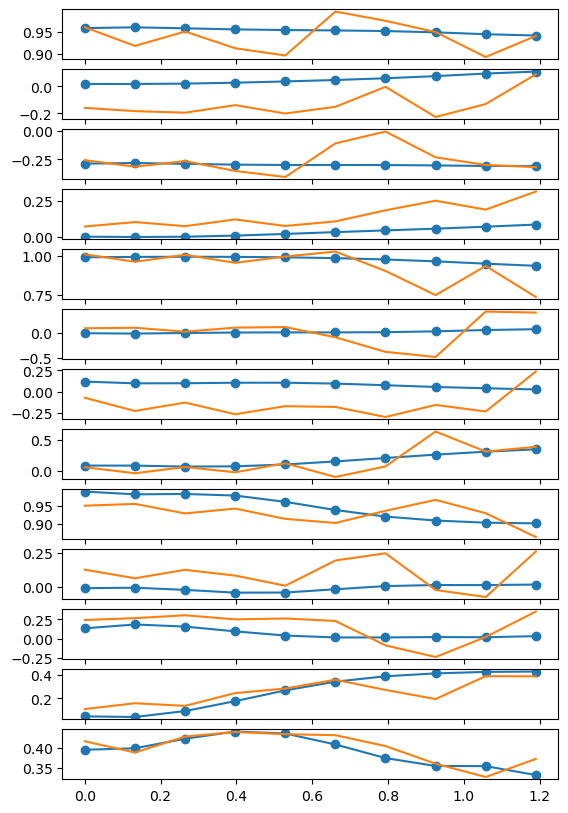

In [44]:
reload (tr);
import matplotlib.pyplot as plt
tr.plot_results(solution,traj,time,num_nodes)

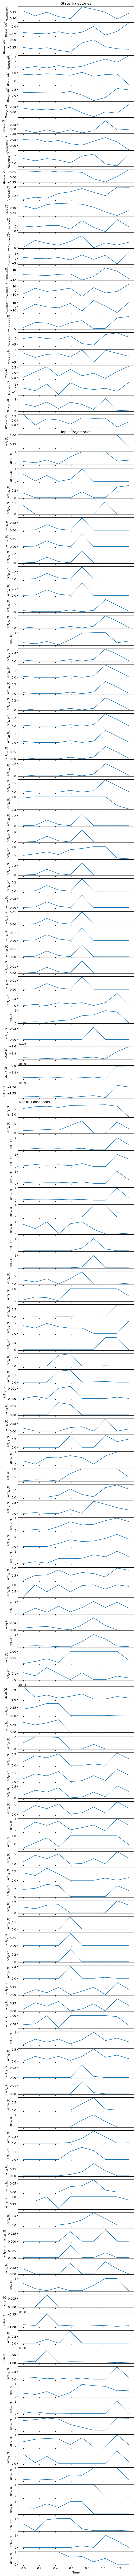

In [ ]:
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
#                          figsize=(6.4, 0.8*(num_states+num_inputs)),
#                          layout='compressed')
# prob.plot_trajectories(solution, axes=axes)

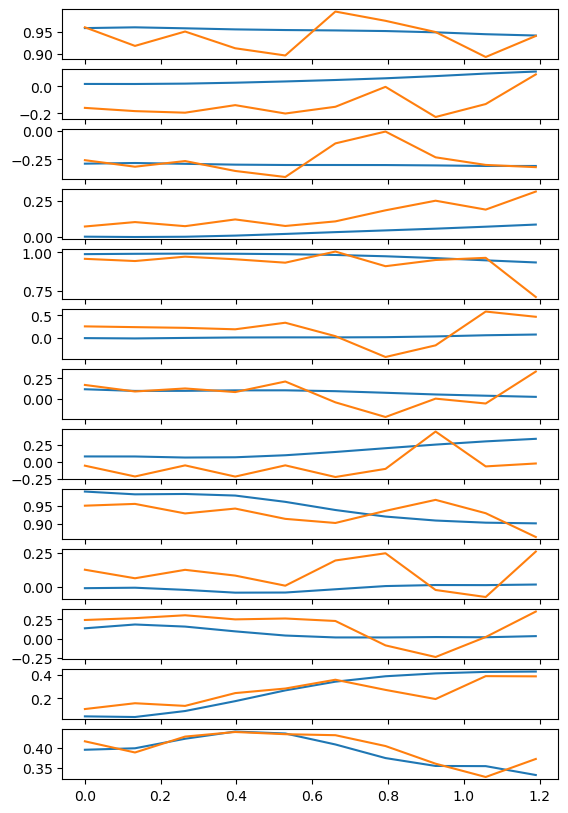

In [43]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j,:])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [ ]:
import trajectory_lib as tr
reload (tr);
num_iter_sol = int(input('enter number of iterarions:'))
file_name = '../Motions/'+motion_folder+'/' + struct_name
tr.sol2struct(solution,activations,len(q),num_states,num_nodes,time,num_iter_sol,time_2_solve,file_name)

Saved to .mat file


In [ ]:
import trajectory_lib as tr
reload (tr);

file_name_mot = '../Motions/'+motion_folder+'/results_quat_scapglob.mot'
tr.sol2mot_quat(solution,num_nodes,13,time,file_name_mot)


Saved to .mot file
